# Problem set 4: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 48 


## Resources from class

### APIs
- [Lecture slides](https://docs.google.com/presentation/d/1eblPOhpOL1HDFk3XOh3KvcrFceJ4pwZNUU_fvU8i7uo/edit#slide=id.p)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/06_apis_solutions.ipynb)


### Supervised ML
- [Lecture slides 1](https://docs.google.com/presentation/d/1V6X9aYkYLvyh3Ea0ZSn3qkttqKz7OOPkfvbqYybMi5Q/edit#slide=id.p)
- [Lecture slides 2](https://docs.google.com/presentation/d/13xJTI_GZ2HZYI9OSmezwLUXXFxIrjwHXKz50QUjBF0w/edit)
- [Intro activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://docs.google.com/presentation/d/1HHgrkFtuhGIaPNMd1EOiM-8VtgnF0cwjMcmah8oWmWA/edit?usp=sharing)
- [Example code](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/herbertfreeze/QSS_Public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: change SQL dataset

- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/herbertfreeze/QSS_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
#!pip install census
#!pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
# Create query to pull data
naep_query_math_2015 = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'
)
naep_query_math_2015 

# Use requests to call API
naep_query_math_2015_resp = requests.get(naep_query_math_2015)
naep_query_math_2015_resp

# Get json contents of the response
naep_query_math_2015_json = naep_query_math_2015_resp.json()
naep_query_math_2015_json

# Turn result into a dataframe
naep_math_2015_df = pd.DataFrame(naep_query_math_2015_json['result'])
naep_math_2015_df

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

<Response [200]>

{'status': 200,
 'result': [{'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 275.020976636682,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 275.638637274477,
   'isStatDisplayable': 1,
   'errorFlag': 0}]}

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
1  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0

### What do scores look like between the genders?

The scores look virtualy the same between the genders, with males have a slightly lower mean score (275.02) compared to females (275.64). The difference is so slight (difference female-male = 0.62, most likely statistically insignificant). 

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
# Create query to pull data for multiple years
naep_query_math = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'
)
naep_query_math

# Use requests to call API
naep_query_math_resp = requests.get(naep_query_math)
naep_query_math_resp

# Get json contents of the response
naep_query_math_json = naep_query_math_resp.json()
naep_query_math_json

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

<Response [200]>

{'status': 200,
 'result': [{'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 277.167170641967,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'jurisLabel': 'California',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 274.597823860242,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   's

In [4]:
# Turn result into a dataframe
naep_math_df = pd.DataFrame(naep_query_math_json['result'])
naep_math_df

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  276.608704                  1          0
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.669430                  1          0
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  274.511628                  1          0
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.721824                  1          0

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis minimum at 272 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

In [5]:
male_math = naep_math_df[naep_math_df['varValueLabel']=='Male']
female_math = naep_math_df[naep_math_df['varValueLabel']=='Female']

Text(0.5, 1.0, 'Mean Math Scores of Male and Female Students from 2013-2019')

(272.0, 278.0)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Mean Math Score')

([<matplotlib.axis.XTick at 0x13fc60d50>,
 [Text(2013, 0, '2013'),
  Text(2015, 0, '2015'),
  Text(2017, 0, '2017'),
  Text(2019, 0, '2019')])

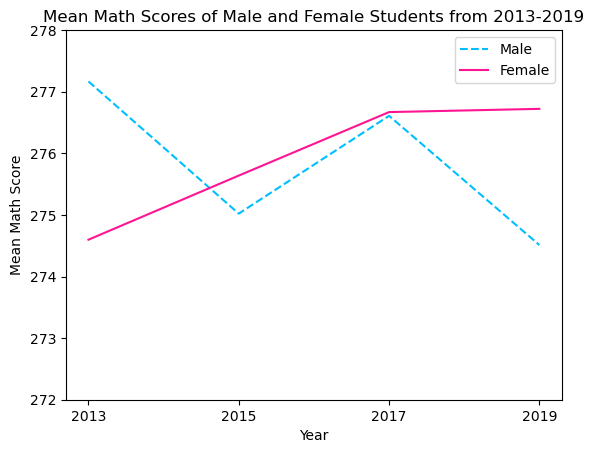

In [6]:
plt.plot(male_math.year, male_math.value, color="deepskyblue", label="Male", linestyle="--")
plt.plot(female_math.year, female_math.value, color="deeppink", label="Female", linestyle="-")
plt.title("Mean Math Scores of Male and Female Students from 2013-2019")
plt.ylim(272,278)
plt.xlabel("Year")
plt.ylabel("Mean Math Score")
plt.legend()
years = range(2013, 2020)
odd_years = [year for year in years if year % 2 != 0] 
plt.xticks(odd_years)

plt.show()

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [7]:
# Define function
def construct_naep_query(year, place):
    if isinstance(year, list):
        year_str = ','.join(year)
        
    else:
        year_str = year

    naep_query = (
        'https://www.nationsreportcard.gov/' +
        'Dataservice/GetAdhocData.aspx?' +
        'type=data&subject=mathematics&grade=8&' +
        'subscale=MRPCM&variable=GENDER&jurisdiction=' + place + '&stattype=MN:MN&' +
        'Year=' + year_str
    )

    return naep_query

In [8]:
# Execute function
print("Single year Query:")
print(construct_naep_query('2015', 'CA'))
print("List of years Query: ")
print(construct_naep_query(['2013', '2015', '2017', '2019'], 'CA'))

Single year Query:
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015
List of years Query: 
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019


In [9]:
assert construct_naep_query('2015', 'CA') == (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&'
    'Year=2015'), "The queries do not match"
print("The queries match")

assert construct_naep_query(['2013', '2015', '2017', '2019'], 'CA') == (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&'
    'Year=2013,2015,2017,2019'), "The queries do not match"
print("The queries match")

The queries match
The queries match


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/herbertfreeze/QSS_public/blob/main/activities/solutions/06_apis_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [10]:
def naep_api_calls(years, 
                   state = 'CA',
                   baseurl='https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?',
                   query_part1='type=data&subject=mathematics&grade=8',
                   query_part2='&subscale=MRPCM&variable=GENDER',
                   query_part3 = '&stattype=MN:MN'):

    dflist = []

    for year in years:
        query = baseurl + query_part1 + query_part2 + ('&jurisdiction=' + state) + query_part3 + ('&Year=' + str(year))
        query_request = requests.get(query) # Call API

        try:
            query_df = pd.DataFrame(query_request.json()['result']) # Convert to dataframe
            dflist.append(query_df)
            
        except Exception as e:
            if e == "ValueError":
                print(f"Failed to get result from API for year {year}")
                print(e)

            # else:
            #     print(f"Failed to get result from API for state {state}")
            #     print(e)

    combined_result_df = pd.concat(dflist)
    
    return combined_result_df

In [11]:
naep_api_calls(years = [2002])

ValueError: No objects to concatenate

In [13]:
naep_api_calls(years = [2013], state = 'ZZ')

ValueError: No objects to concatenate

In [12]:
# Execute the function on the query that pulls 2013-2019 data
naep_api_calls([2013, 2015, 2017, 2019])

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction  jurisLabel variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  274.597824                  1          0
0  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  275.020977                  1          0
1  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  275.638637                  1          0
0  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  276.608704                  1          0
1  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.669430                  1          0
0  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        1          Male  274.511628                  1          0
1  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA  California   GENDER        Gender        2        Female  276.721824                  1          0

In [14]:
# Execute function on state that doesn't exist
naep_api_calls(years = ['2013'],
              state = 'ZZ')

ValueError: No objects to concatenate

# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/ArticleDet?ID=72395))

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

creds = load_creds("../")

census = mysql.connector.connect(user=creds['database']['user'], 
                            password=creds['database']['password'],
                            port=creds['database']['port'],
                            database= creds['database']['database'],
                            host = creds['database']['host'])

census

FileNotFoundError: [Errno 2] No such file or directory: 'new_creds.yaml'

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

#select the first 5 rows + all columns
query = """
SELECT 
    *
FROM math_gencompare
LIMIT 5
"""

#read results
first_five = pd.read_sql_query(query, census)

#print results
first_five

In [ ]:
## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [ ]:
# your code here

part1 = """
SELECT COUNT(*) 
FROM math_gencompare
"""

part2 = """
SELECT COUNT(DISTINCT state) 
FROM math_gencompare
"""

part3 = """
SELECT COUNT(DISTINCT year) 
FROM math_gencompare
"""


#read results into df
df1 = pd.read_sql_query(part1, census)
df2 = pd.read_sql_query(part2, census)
df3 = pd.read_sql_query(part3, census)

#print

df1
df2
df3

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [ ]:
#when male > female assign 1
part4 = """
SELECT state, year,
CASE WHEN male > female
THEN 1
ELSE 0
END AS is_male_higher
FROM math_gencompare
"""

#read in the results
df4 = pd.read_sql_query(part4, census)

#print the head
df4.head()

#find the mean across all rows
row_mean = df4['is_male_higher'].mean()
row_mean

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [ ]:
#A
#use avg to find percentage then groupby year
part5 = """
SELECT year,
AVG(CASE WHEN male > female
THEN 100
ELSE 0 
END) AS percent_male_higher
FROM math_gencompare
GROUP BY year;
"""
df5 = pd.read_sql_query(part5, census)

#B
#print the df
df5


## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [ ]:
#A
part6 = """
SELECT state,
AVG(CASE WHEN male > female
THEN 100
ELSE 0 
END) AS percent_higher_male
FROM math_gencompare
GROUP BY state;
"""

#read it as a df
df6 = pd.read_sql_query(part6, census)
#df6

In [ ]:
#sort the df
df6_sorted = df6.sort_values(by='percent_higher_male', ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(df6_sorted['state'], df6_sorted['percent_higher_male'])  # Horizontal bar plot
plt.title('Percentage of Years with Higher Male Scores by State')  # Adding a title
plt.xlabel('Percent Male Higher')  # Labeling the x-axis
plt.ylabel('State')  # Labeling the y-axis
plt.show()


## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_voter` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_voter` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [ ]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]

#A
#using help from stack overflow
#combine state names whilst preserving quotes
combined_list_suffrage = ', '.join(f"'{state}'" for state in list_suffrage)

#create indicator
part7 = f"""
SELECT state, 
       CASE WHEN state IN ({combined_list_suffrage}) 
       THEN 1 
       ELSE 0 
       END AS is_early_voter
FROM math_gencompare
GROUP BY state;
"""

#read as pandas df
df7 = pd.read_sql_query(part7, census)

df7

In [ ]:
#B
#create indicator
part7b = f"""
SELECT year,is_early_voter,
AVG(CASE WHEN percent_higher_male > 50 
THEN 100 
ELSE 0 
END) AS percent_states_male_higher
FROM (
SELECT year, state, 
AVG(CASE WHEN male > female 
THEN 100 
ELSE 0 
END) AS percent_higher_male,
CASE 
WHEN state IN ({combined_list_suffrage}) 
THEN 1 
ELSE 0 
END AS is_early_voter
FROM math_gencompare
GROUP BY year, state
) AS subquery
GROUP BY year, is_early_voter;
"""

#C 
#read into pandas df
df7b = pd.read_sql_query(part7b, census)

#Print 
df7b

# 3. Explore variation in math score disparities and trends (18 points)

## 3.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [16]:
# Load file
acs = pd.read_pickle("acs_wmath.pkl")

acs.head()

math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0        281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1        268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2        278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3        279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                                  

## 3.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


In [17]:
# Create new column for gender disparity (Male - Female)
acs['gender_disparity'] = acs['math_male_2013'] - acs['math_female_2013']

# Print updated dataframe
acs[['math_male_2013', 'math_female_2013', 'gender_disparity']]

math_male_2013  math_female_2013  gender_disparity
0       281.723376        281.388243          0.335133
1       269.457456        268.920112          0.537344
2       277.457662        278.381788         -0.924126
3       280.174389        279.249581          0.924807
4       277.167171        274.597824          2.569347
5       289.454320        289.923675         -0.469354
6       285.474592        285.001719          0.472873
7       283.830455        280.819272          3.011183
8       281.654866        280.041721          1.613144
9       279.446739        278.897697          0.549042
10      279.503381        283.519308         -4.015928
11      285.734439        284.381733          1.352706
12      286.976906        285.831705          1.145201
13      285.037468        284.751037          0.286431
14      288.213645        287.306602          0.907043
15      290.261606        288.733125          1.528481
16      280.989580        280.282609          0.706971
17      272.610984        272.914362         -0.303378
18      300.904212        300.230890          0.673322
19      286.397218        286.894080         -0.496862
20      290.310425        287.042353          3.268072
21      279.713426        280.579895         -0.866468
22      295.404318        293.775600          1.628718
23      282.657909        283.332222         -0.674313
24      271.109404        271.214224         -0.104821
25      289.053257        289.414157         -0.360900
26      285.466840        285.830669         -0.363829
27      290.802638        290.218517          0.584121
28      284.871870        285.259674         -0.387805
29      295.229753        296.126425         -0.896672
30      295.223058        296.932719         -1.709661
31      272.756076        272.767820         -0.011745
32      279.090456        277.441711          1.648744
33      280.379929        283.336573         -2.956644
34      289.993062        289.044420          0.948642
35      274.832878        276.191859         -1.358981
36      284.638917        282.337649          2.301268
37      290.340628        288.856549          1.484079
38      284.310518        283.860837          0.449681
39      280.812610        278.835771          1.976839
40      287.763809        286.748713          1.015097
41      277.773516        277.664098          0.109418
42      288.563080        287.809163          0.753917
43      284.868183        283.764719          1.103464
44      287.504853        288.806250         -1.301397
45      294.792950        296.187564         -1.394613
46      290.475682        289.404324          1.071358
47      288.699963        288.793559         -0.093595
48      274.493148        274.367421          0.125727
49      289.561863        286.559635          3.002228

<Figure size 1300x900 with 0 Axes>

<BarContainer object of 50 artists>

Text(0.5, 0, 'States')

Text(0, 0.5, 'Gender Disparity of Math Scores (Male - Female)')

Text(0.5, 1.0, 'Gender Disparity of 2013 Math Scores Across U.S. States')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Alaska'),
  Text(1, 0, 'Alabama'),
  Text(2, 0, 'Arkansas'),
  Text(3, 0, 'Arizona'),
  Text(4, 0, 'California'),
  Text(5, 0, 'Colorado'),
  Text(6, 0, 'Connecticut'),
  Text(7, 0, 'Delaware'),
  Text(8, 0, 'Florida'),
  Text(9, 0, 'Georgia'),
  Text(10, 0, 'Hawaii'),
  Text(11, 0, 'Iowa'),
  Text(12, 0, 'Idaho'),
  Text(13, 0, 'Illinois'),
  Text(14, 0, 'Indiana'),
  Text(15, 0, 'Kansas'),
  Text(16, 0, 'Kentucky'),
  Text(17, 0, 'Louisiana'),
  Text(18, 0, 'Massachusetts'),
  Text(19, 0, 'Maryland'),
  Text(20, 0, 'Maine'),
  Text(21, 0, 'Michigan'),
  Text(22, 0, 'Minnesota'),
  Text(23, 0, 'Missouri'),
  Text(24, 0, 'Mississippi'),
  Text(25, 0, 'Montana'),
  Text(26, 0, 'North Car

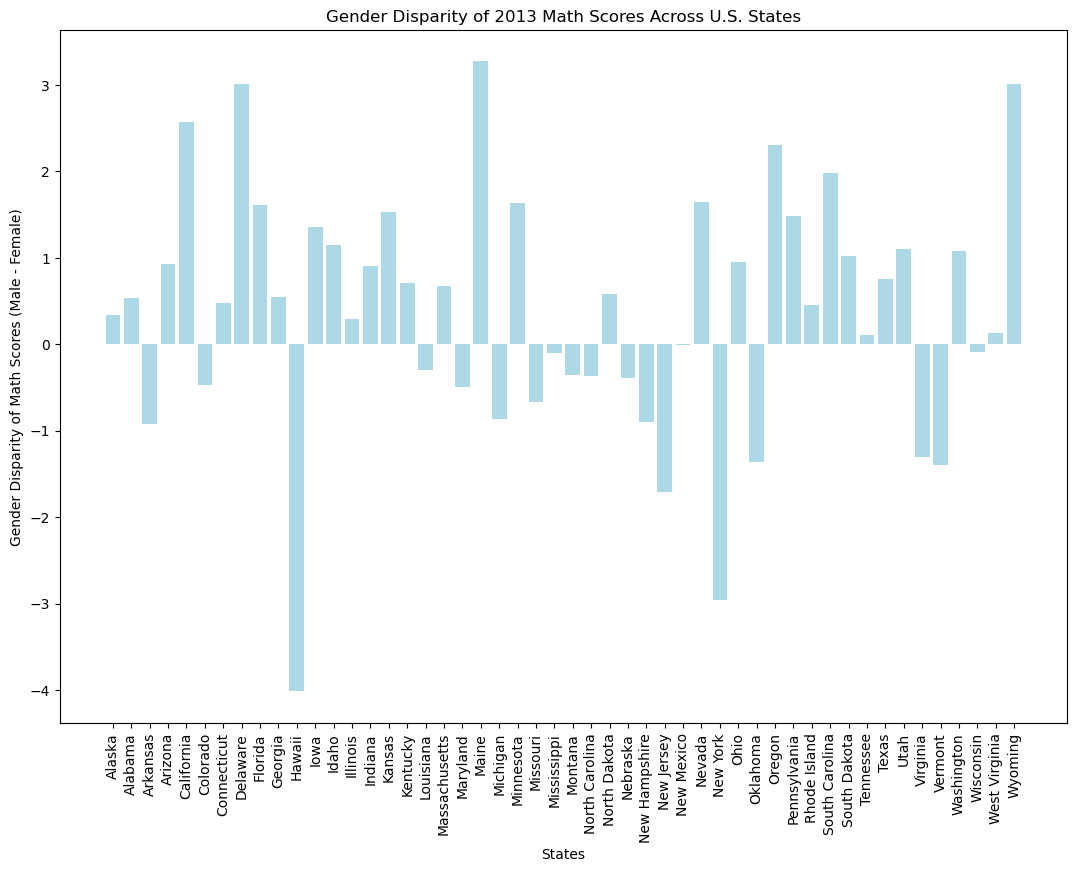

In [37]:
# Create visualization
plt.figure(figsize = (13, 9))
plt.bar(acs.state, acs.gender_disparity, color = 'lightblue')
plt.xlabel('States')
plt.ylabel('Gender Disparity of Math Scores (Male - Female)')
plt.title('Gender Disparity of 2013 Math Scores Across U.S. States')
plt.xticks(rotation=90)

plt.show()

## 3.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a scatterplot (or seaborn regplot) of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [19]:
## A - Indicator variable where males are doing better than females
acs['males_better'] = np.where(acs['gender_disparity'] > 0, True, False)

acs[['gender_disparity', 'males_better']]

gender_disparity  males_better
0           0.335133          True
1           0.537344          True
2          -0.924126         False
3           0.924807          True
4           2.569347          True
5          -0.469354         False
6           0.472873          True
7           3.011183          True
8           1.613144          True
9           0.549042          True
10         -4.015928         False
11          1.352706          True
12          1.145201          True
13          0.286431          True
14          0.907043          True
15          1.528481          True
16          0.706971          True
17         -0.303378         False
18          0.673322          True
19         -0.496862         False
20          3.268072          True
21         -0.866468         False
22          1.628718          True
23         -0.674313         False
24         -0.104821         False
25         -0.360900         False
26         -0.363829         False
27          0.584121          True
28         -0.387805         False
29         -0.896672         False
30         -1.709661         False
31         -0.011745         False
32          1.648744          True
33         -2.956644         False
34          0.948642          True
35         -1.358981         False
36          2.301268          True
37          1.484079          True
38          0.449681          True
39          1.976839          True
40          1.015097          True
41          0.109418          True
42          0.753917          True
43          1.103464          True
44         -1.301397         False
45         -1.394613         False
46          1.071358          True
47         -0.093595         False
48          0.125727          True
49          3.002228          True

<Axes: xlabel='math_male_2013', ylabel='median_household_income'>

Text(0, 0.5, 'Median Household Income')

Text(0.5, 0, 'Male Math Score (2013)')

Text(0.5, 1.0, 'Median Household Income vs. Male Math Scores (2013)')

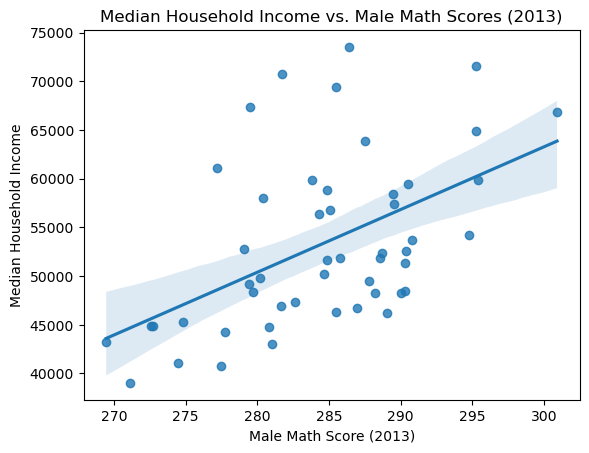

In [24]:
## B - Scatterplot of median household income vs. math_male_2013

# Rename median household income column name
acs.rename(columns = {'acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars':
                     'median_household_income'}, inplace = True)


# Scatterplot
sns.regplot(x = acs['math_male_2013'], y = acs['median_household_income'])

plt.ylabel('Median Household Income')
plt.xlabel('Male Math Score (2013)')
plt.title('Median Household Income vs. Male Math Scores (2013)')

plt.show()

<Axes: xlabel='math_female_2013', ylabel='median_household_income'>

Text(0, 0.5, 'Median Household Income')

Text(0.5, 0, 'Female Math Score (2013)')

Text(0.5, 1.0, 'Median Household Income vs. Female Math Scores (2013)')

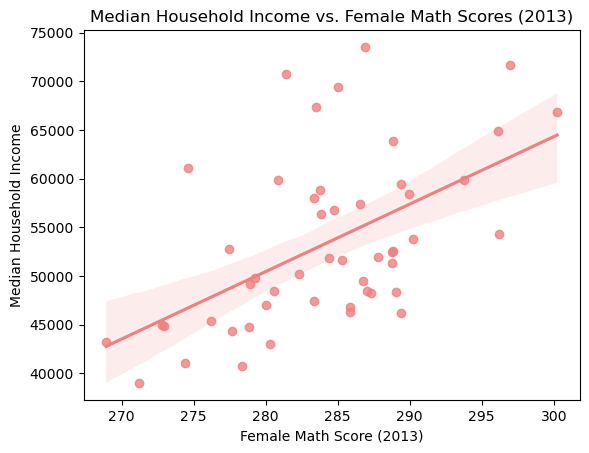

In [23]:
## B - Scatterplot of median household income vs. math_female_2013

# Scatterplot
sns.regplot(x = acs['math_female_2013'], y = acs['median_household_income'], color = 'lightcoral')

plt.ylabel('Median Household Income')
plt.xlabel('Female Math Score (2013)')
plt.title('Median Household Income vs. Female Math Scores (2013)')

plt.show()

In [40]:
# Male performance & median household income
print("Male Performance vs. Median Household Income:")
print(np.corrcoef(acs.math_male_2013, acs.median_household_income)[0,1])

print("\n")

# Female performance & median household income
print("Female Performance vs. Median Household Income:")
print(np.corrcoef(acs.math_female_2013, acs.median_household_income)[0,1])

print("\n")

# Indicator (males_better) & median household income
print("Males Performing Better Than Females vs. Median Household Income:")
print(np.corrcoef(acs.males_better, acs.median_household_income)[0,1])



Male Performance vs. Median Household Income:
0.5073471931940419


Female Performance vs. Median Household Income:
0.5433780349589303


Males Performing Better Than Females vs. Median Household Income:
-0.03387519833365424


### D. Interpret the correlations:
**Do...(a) boys tend to perform better than boys in states with lower MHI? (b) girls tend to perform better than girls in states with lower MHI? (c) boys tend to outperform girls more than they do in states with lower MHI?**







(a & b): As the correlation coefficient indicates, as the MHI increases, boys and girls both tend to perform better than their counterparts in states with lower MHI. For boys, this correlation coefficient is 0.507, and for girls, this correlation coefficient is 0.543; therefore, the relationship is slightly stronger for girls than boys. 

(c): Additionally, girls actually tend to outperform boys more than they do in states with lower MHI as indicated by the negative correlation coefficient measuring when males perform better than females against median household incomes in each state. Specifically, the correlation coefficient is -0.034.

## 3.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019). With 50 states, your final shape should be (200,84).
- See: https://pandas.pydata.org/docs/reference/api/pandas.melt.html

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. Your covariates should have the term 'acspredict' in it.

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [26]:
# A. your code here to load data
acs2 = pd.read_pickle("acs_wmath.pkl")

acs2.head()

math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0        281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1        268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2        278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3        279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                                  

In [27]:
# B. your code here to construct binary indicators for male higher
years_list = [2013, 2015, 2017, 2019]
for year in years_list:
    acs2['outcome_male_higher_female_' + str(year)] = np.where(acs2['math_male_' + str(year)] > acs2['math_female_' + str(year)],
                                                             True, False)

# Remove raw math score columns
no_math = [col for col in acs2.columns if 'math' not in col]
acs2_new = acs2[no_math]

# Print new dataframe
acs2_new.head()

abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3     AZ   04                                                                                                                                                                                     

In [28]:
# C. your code here to melt data
acs2_melt = pd.melt(acs2_new, id_vars = acs2_new.loc[:, 'abbrev':'state'], value_vars = ['outcome_male_higher_female_2013',
                                                                'outcome_male_higher_female_2015',
                                                                'outcome_male_higher_female_2017',
                                                                'outcome_male_higher_female_2019'])

In [29]:
acs2_melt

abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0       AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1       AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2       AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3       AZ   04                                                                                                                                                                             

In [30]:
acs2_melt.shape

(200, 86)

D. Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test

In [73]:
# D. your code here for train/test split

# Get unique states
unique_states = acs2_melt.state.unique()

# Randomly select 35 states to train & 15 states to test
train_states = pd.Series(unique_states).sample(n = 35, random_state=67)
train_states_list = set(train_states)

# Check that right number of states were generated for each category
print("Number of states:")
test_states_list = set(unique_states) - train_states_list
len(train_states_list)
len(test_states_list)

# Generate new data frames with the train and test states
train_df = acs2_melt[acs2_melt.state.isin(train_states_list)]
test_df = acs2_melt[acs2_melt.state.isin(test_states_list)]

print("Dimensions of new dataframes for test and train:")
train_df.shape
test_df.shape

Number of states:


35

15

Dimensions of new dataframes for test and train:


(140, 86)

(60, 86)

In [82]:
# E. your code here to normalize features and fit model
from sklearn.preprocessing import StandardScaler

# Divide into X and y

# train and test split into features and target
X_train = train_df.loc[:, 'FIPS':'acspredict_ratio_of_income_to_poverty_level_of_families_in_the_past_12_monthsestimatetotalunder 50']
X_test = test_df.loc[:, 'FIPS':'acspredict_ratio_of_income_to_poverty_level_of_families_in_the_past_12_monthsestimatetotalunder 50']

y_train = train_df[['value']]
y_test = test_df[['value']]

# Load scaler
scaler = StandardScaler()

# Normalize features
scaler.fit(X_train)
scaler.transform(X_test)

StandardScaler()

array([[-1.60471409, -1.05607593,  1.24866577, ..., -0.4177225 ,
         0.64620001,  1.12974313],
       [-1.35509189, -0.83346253, -0.57379232, ...,  0.85556453,
        -0.62631249, -0.44177736],
       [-1.2302808 ,  0.58869978,  0.68317376, ...,  0.72786767,
        -1.19416295, -0.82627973],
       ...,
       [ 0.95391337, -0.21703231,  1.28334283, ..., -0.84419685,
         1.00034344,  1.41552704],
       [ 1.14113002,  0.20538199,  0.66361015, ..., -0.25458041,
         1.57757573,  0.88872042],
       [ 1.26594111,  0.51729931, -1.12469786, ...,  0.31276216,
        -0.8230142 , -1.18615078]])

In [83]:
# Decision tree
dt_classifier = DecisionTreeClassifier(criterion='gini',
                                      splitter='best',
                                      max_depth = 5,
                                      min_samples_split = 5,
                                      min_samples_leaf = 10,
                                      min_weight_fraction_leaf = 0.0,
                                      max_features = None,
                                      max_leaf_nodes = None,
                                      min_impurity_decrease = 1e-07,
                                      random_state = 23)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_impurity_decrease=1e-07,
                       min_samples_leaf=10, min_samples_split=5,
                       random_state=23)

In [94]:
# Classify feature and label names
features = X_train.columns

[Text(0.4444444444444444, 0.9166666666666666, 'acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdshouseholderfemale <= 0.106\ngini = 0.499\nsamples = 140\nvalue = [67, 73]\nclass = a'),
 Text(0.2222222222222222, 0.75, 'acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemalenot living alone <= 0.01\ngini = 0.399\nsamples = 40\nvalue = [11, 29]\nclass = a'),
 Text(0.1111111111111111, 0.5833333333333334, 'gini = 0.18\nsamples = 20\nvalue = [2, 18]\nclass = a'),
 Text(0.3333333333333333, 0.5833333333333334, 'gini = 0.495\nsamples = 20\nvalue = [9, 11]\nclass = a'),
 Text(0.6666666666666666, 0.75, 'acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdsnonrelativesother nonrelatives <= 0.005\ngini = 0.493\nsamples = 100\nvalue = [56, 44]\nclass = v'),
 Text(0.5555555555555556, 0.5833333333333334,

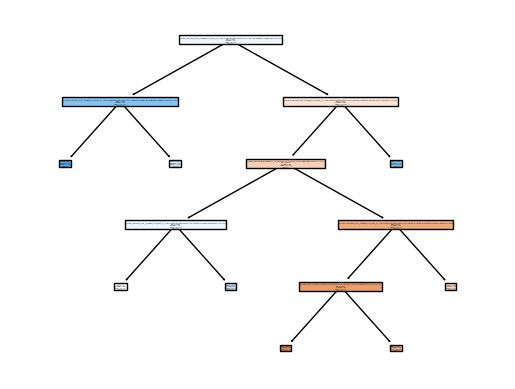

In [95]:
# Plot decision tree
from sklearn import tree
tree.plot_tree(dt_classifier, 
                   feature_names=features,  
                   class_names="value",
                   filled=True)
print("")

In [96]:
# F. your code here to interpret feature importances
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train)



# print(f"model score on training data: {model.score(X_train, y_train)}")
# print(f"model score on testing data: {model.score(X_test, y_test)}")



RandomForestRegressor()

In [97]:
# G. your code here to evaluate model
precision_score(y_test, y_train)
recall_score(y_test, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [60, 140]

G. Evaluate the precision and recall of that model in the test set states without using the score, precision, or recall functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?